In [2]:
import pandas as pd
from glob import glob
from os import path, listdir, mkdir
from matplotlib import rc
from matplotlib import pyplot as plt
from scipy.spatial.distance import squareform, pdist
from scipy.cluster.hierarchy import dendrogram, linkage
from PIL import Image

In [3]:
def hclust(aai_file, metadata):
    """
    aai_file: CompareM outputfile
    metadata = pd.DataFrame
    """
    df = pd.read_csv(aai_file, sep="\t")
    df["#Genome A"] = df["#Genome A"].str.split("_genomic", expand=True).iloc[:, 0].str[:15]
    df["Genome B"] = df["Genome B"].str.split("_genomic", expand=True).iloc[:, 0].str[:15]
    df_ = df.rename(columns={"#Genome A": "Genome B", "Genome B": "#Genome A"})
    df_t = pd.concat([df, df_], sort=True)
    
    table = pd.pivot_table(
    df_t,
    values="Mean AAI",
    index = ("#Genome A"),
    columns = ("Genome B")
)
    table = table.fillna(value=99.99)
    qc_filter = [i for i in metadata["assembly_accession"] if i in table.columns]
    table = table[qc_filter].loc[qc_filter]
    renaming_dict = pd.Series(metadata["label"].values,
                              index=metadata["assembly_accession"]).to_dict()
    
    table.rename(columns = renaming_dict, index=renaming_dict, inplace=True)
    
    X = abs(table - 99.99)
    X = squareform(X)
    Z = linkage(X,
            method="complete",
            metric="cityblock",
            optimal_ordering=True
           )
    
    return (Z, table.columns)


def augmented_dendrogram(*args, **kwargs):

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        for i, d in zip(ddata['icoord'], ddata['dcoord']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > 1.5:
                plt.plot(x, y, 'ro')
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -8),
                         textcoords='offset points',
                         va='top', ha='center')

    return ddata


def plot_hclust(Z, columns, figsize=False, save=False, rotate=True):
    if figsize:
        fig = plt.figure(figsize=figsize)
    
    dn = augmented_dendrogram(Z,
                              labels = columns,
                              leaf_rotation=-90,
                              color_threshold=30,
                              leaf_font_size=9,
                             )
    
    if save:
        plt.savefig(save, dpi=1200, bbox_inches="tight")
    else:
        rotate=False
        
    if rotate:
        im = Image.open(save)
        im = im.rotate(90, expand=True)
        im.save(save)

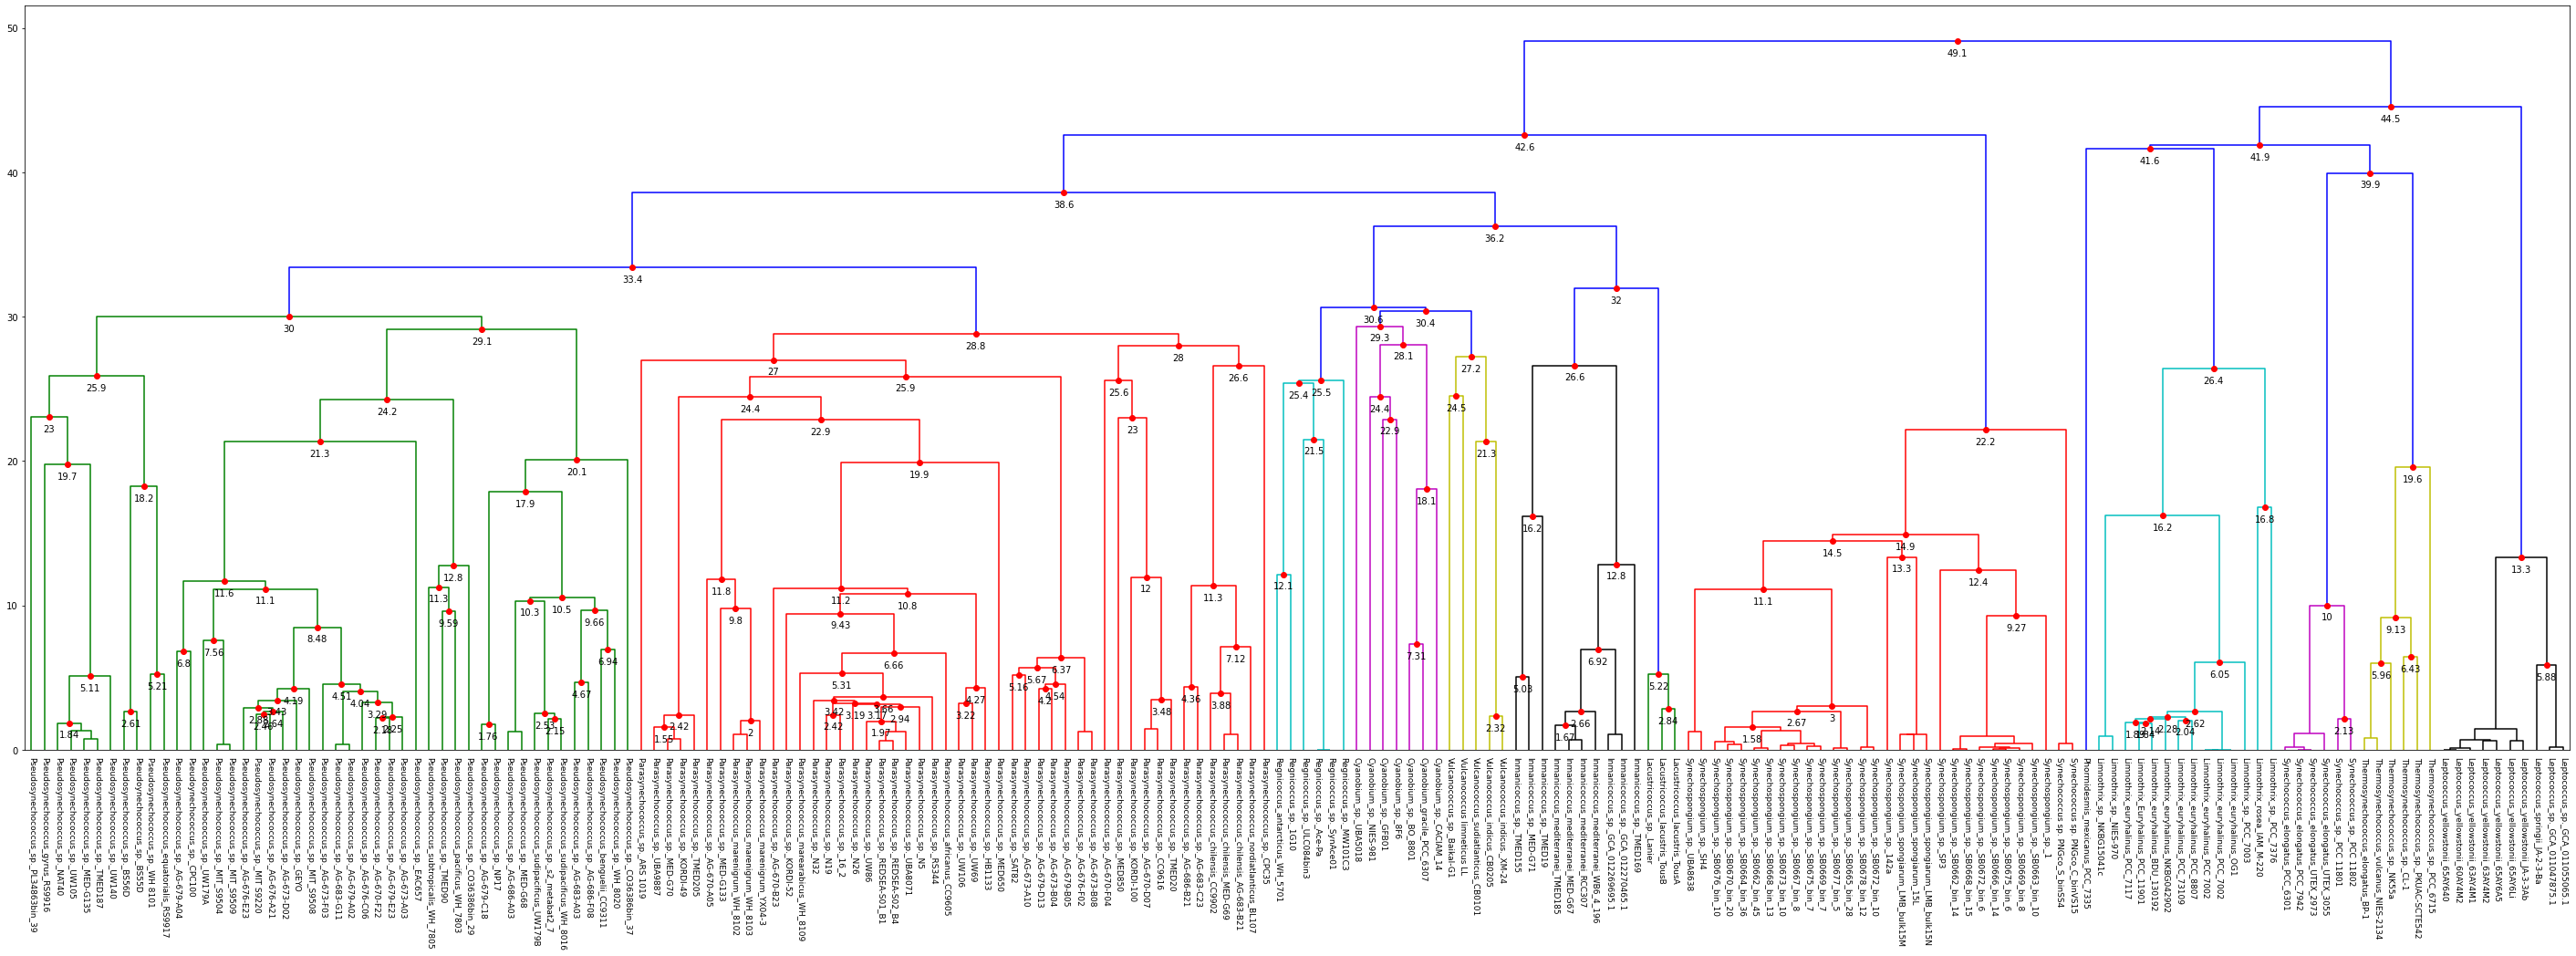

In [4]:
metadata = pd.read_csv("../data/metadata.csv")
metadata['no_genus'] = metadata.groupby('new_genus')[
    'new_genus'].transform('count').map(int, na_action="ignore")
Z, columns = hclust("../data/comparem/output/aai/aai_summary.tsv", 
                    metadata=metadata[(metadata['is_synecho']) & (metadata['quality_filter']) & (metadata['no_genus'] > 1)])
plot_hclust(Z, columns, figsize=(50,15))

In [7]:
metadata[(metadata['is_synecho']) & (metadata['quality_filter']) & (metadata['no_genus'] > 0)]

,assembly_accession,bioproject,biosample,wgs_master,excluded_from_refseq,refseq_category,relation_to_type_material,taxid,species_taxid,isolate,...,megabases,organism_name,infraspecific_name,new_genus,new_species,new_strain,label,protein_filename,gtt_label,no_genus
0,GCA_009919765.1,PRJNA495371,SAMN10223114,RGBH00000000.1,derived from metagenome,na,NaN,1131,1131,WB6_4_196,...,1.774171,Synechococcus sp.,NaN,Inmanicoccus,mediterranei,WB6_4_196,Inmanicoccus_mediterranei_WB6_4_196,GCA_009919765.1_ASM991976v1_genomic_prodigal_p...,Inmanicoccus_mediterranei_WB6_4_196 # GCA_0099...,10
1,GCA_011047875.1,PRJNA480137,SAMN09639364,DSMC00000000.1,derived from metagenome,na,NaN,1131,1131,SpSt-285,...,2.960570,Synechococcus sp.,NaN,Leptococcus,yellowstonii,GCA_011047875.1,Leptococcus_sp._GCA_011047875.1,GCA_011047875.1_ASM1104787v1_genomic_prodigal_...,Leptococcus_sp._GCA_011047875.1 # GCA_011047875.1,10
2,GCA_011055065.1,PRJNA480137,SAMN09639229,DSGY00000000.1,derived from metagenome,na,NaN,1131,1131,SpSt-164,...,2.895453,Synechococcus sp.,NaN,Leptococcus,yellowstonii,GCA_011055065.1,Leptococcus_sp._GCA_011055065.1,GCA_011055065.1_ASM1105506v1_genomic_prodigal_...,Leptococcus_sp._GCA_011055065.1 # GCA_011055065.1,10
3,GCA_012269695.1,PRJNA545004,SAMN12098012,JAAXJU000000000.1,derived from metagenome,na,NaN,1131,1131,SW42618_bin_11,...,1.553595,Synechococcus sp.,NaN,Inmanicoccus,sp.,GCA_012269695.1,Inmanicoccus_sp._GCA_012269695.1,GCA_012269695.1_ASM1226969v1_genomic_prodigal_...,Inmanicoccus_sp._GCA_012269695.1 # GCA_0122696...,10
4,GCA_012270465.1,PRJNA545004,SAMN12098011,JAAXIH000000000.1,derived from metagenome,na,NaN,1131,1131,SW22112_bin_11,...,1.784620,Synechococcus sp.,NaN,Inmanicoccus,sp.,GCA_012270465.1,Inmanicoccus_sp._GCA_012270465.1,GCA_012270465.1_ASM1227046v1_genomic_prodigal_...,Inmanicoccus_sp._GCA_012270465.1 # GCA_0122704...,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,GCA_000708525.1,PRJNA246088,SAMN02767986,JMRP00000000.1,derived from metagenome,na,NaN,1496688,1496688,NaN,...,3.212489,Cyanobium sp. CACIAM 14,NaN,Cyanobium,Cyanobium sp000708525,NaN,Cyanobium_sp._CACIAM_14,GCA_000708525.1_ASM70852v1_genomic_prodigal_pr...,Cyanobium_sp._CACIAM_14 # GCA_000708525.1,8
638,GCA_900088535.1,PRJEB14035,SAMEA4005231,NaN,NaN,na,NaN,1851505,1851505,NaN,...,3.021545,Cyanobium sp. NIES-981,strain=NIES-981,Cyanobium,PCC7001 sp900088535,strain=NIES-981,Cyanobium_sp._NIES-981,GCA_900088535.1_ASM90008853v1_genomic_prodigal...,Cyanobium_sp._NIES-981 # GCA_900088535.1,8
695,GCA_002396505.1,PRJNA348753,SAMN06452430,DGYA00000000.1,derived from metagenome,na,NaN,1947887,1947887,UBA5018,...,3.045003,Cyanobacteria bacterium UBA5018,NaN,Cyanobium,PCC7001 sp002396505,NaN,Cyanobium_sp._UBA5018,GCA_002396505.1_ASM239650v1_genomic_prodigal_p...,Cyanobium_sp._UBA5018 # GCA_002396505.1,8
1075,GCA_003249115.1,PRJNA436342,SAMN08895991,QBMD00000000.1,derived from metagenome,na,NaN,2164130,2164130,ULC084bin3,...,2.820113,Regnicoccus sp.,NaN,Regnicoccus,sp.,GCA_003249115.1,Regnicoccus_sp._ULC084bin3,GCA_003249115.1_ASM324911v1_genomic_prodigal_p...,Regnicoccus_sp._ULC084bin3 # GCA_003249115.1,6


In [7]:
def parse_label(row):

    split = row.replace(" ", "_").split("_")
    genus = split[0]
    species = split[1]
    strain = " ".join(split[2:])

    strain = "\ \mathrm{" + strain + "}"
    if species == "sp.":
        species = " \mathrm{" + species + "}"
    label = f'${genus}\ {species} {strain}$'
    return label

In [ ]:
metadata = pd.read_csv("../data/metadata.csv")
metadata['no_genus'] = metadata.groupby('new_genus')[
    'new_genus'].transform('count').map(int, na_action="ignore")
metadata=metadata[(metadata['is_synecho']) & (metadata['quality_filter']) & (metadata['no_genus'] > 0)]
metadata['label'] = metadata['label'].apply(lambda row: parse_label(row))
Z, columns = hclust("../data/comparem/output/aai/aai_summary.tsv", metadata=metadata)
plot_hclust(Z, columns, figsize=(50,15), save="../data/plots/final/Figure_2_AAI.eps", rotate=True)

In [1]:
Z

NameError: name 'Z' is not defined

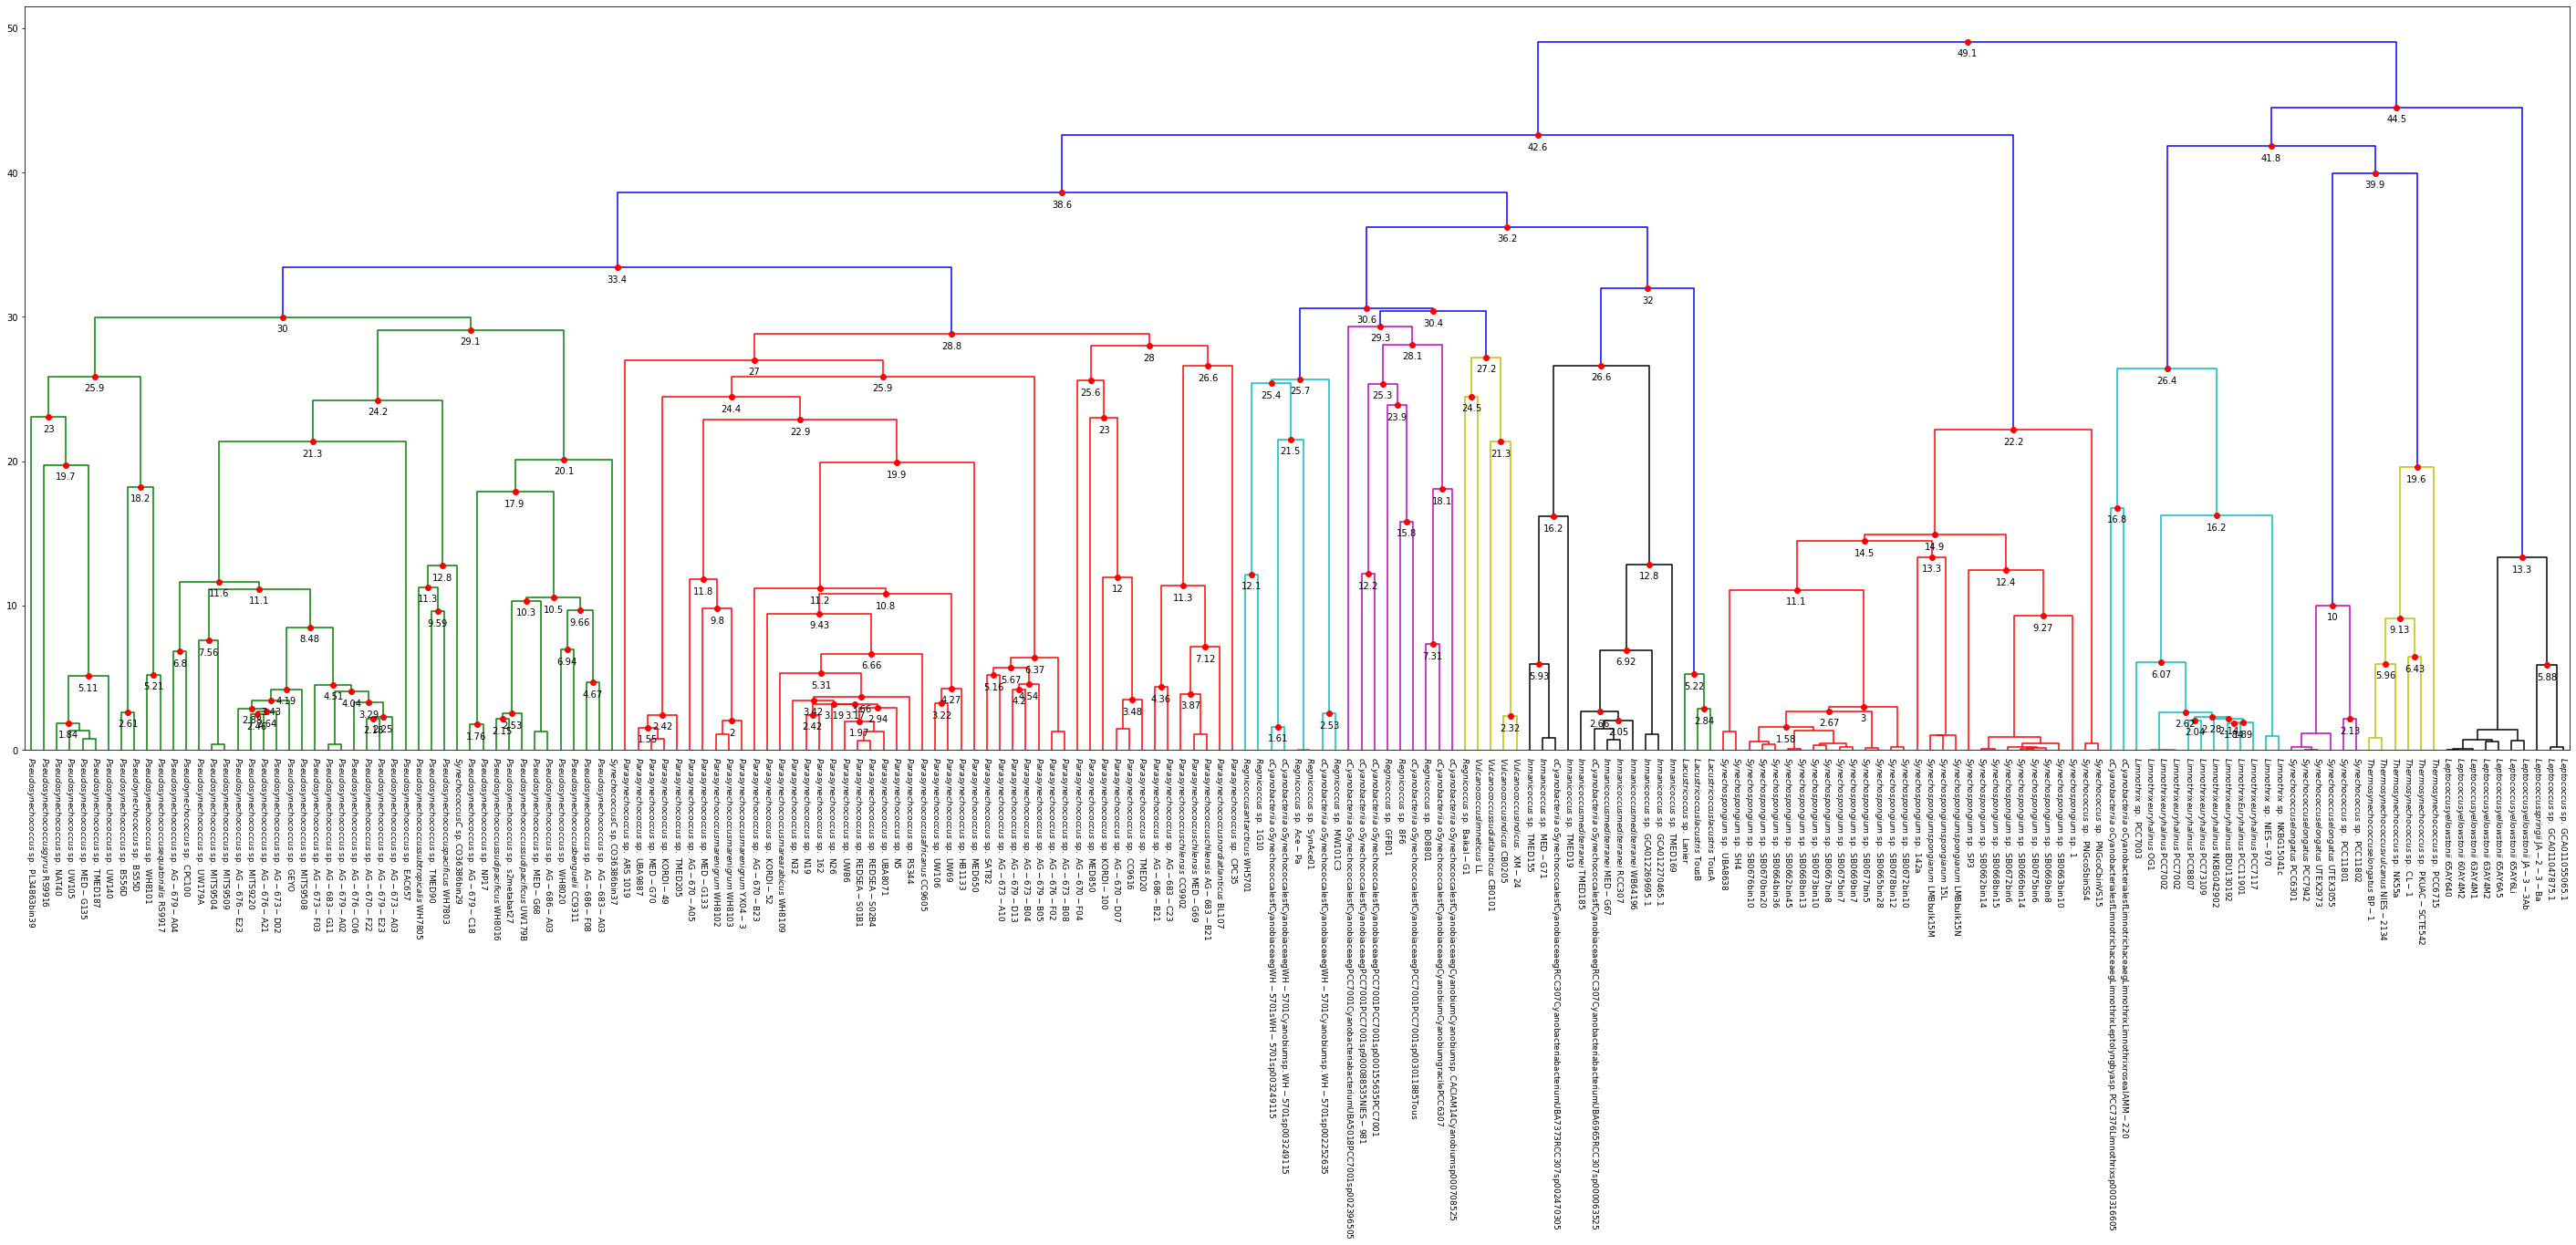

In [80]:
Z, columns = hclust("../data/comparem/output/aai/aai_summary.tsv", 
                    metadata=metadata[(metadata['is_synecho']) |
                                      metadata['label'].apply(lambda s: any(i in s for i in ("SS2", "SS35", "SS52", "SS51", "CCMP1375"))) &
                                      (metadata['quality_filter']) &
                                      (metadata['label'].apply(lambda s: any([i in s for i in [
                        "Parasynechococcus", "Pseudosynechococcus", "Vulcanococcus", "Regnicoccus", "Lacustricoccus", "Inmanicoccus", "Synechospongium", "Prochlorococcus"]])))])
plot_hclust(Z, columns, figsize=(50,15), save="../data/plots/aai/aai_cyanobiaceae_and_prochlorococcus.png")

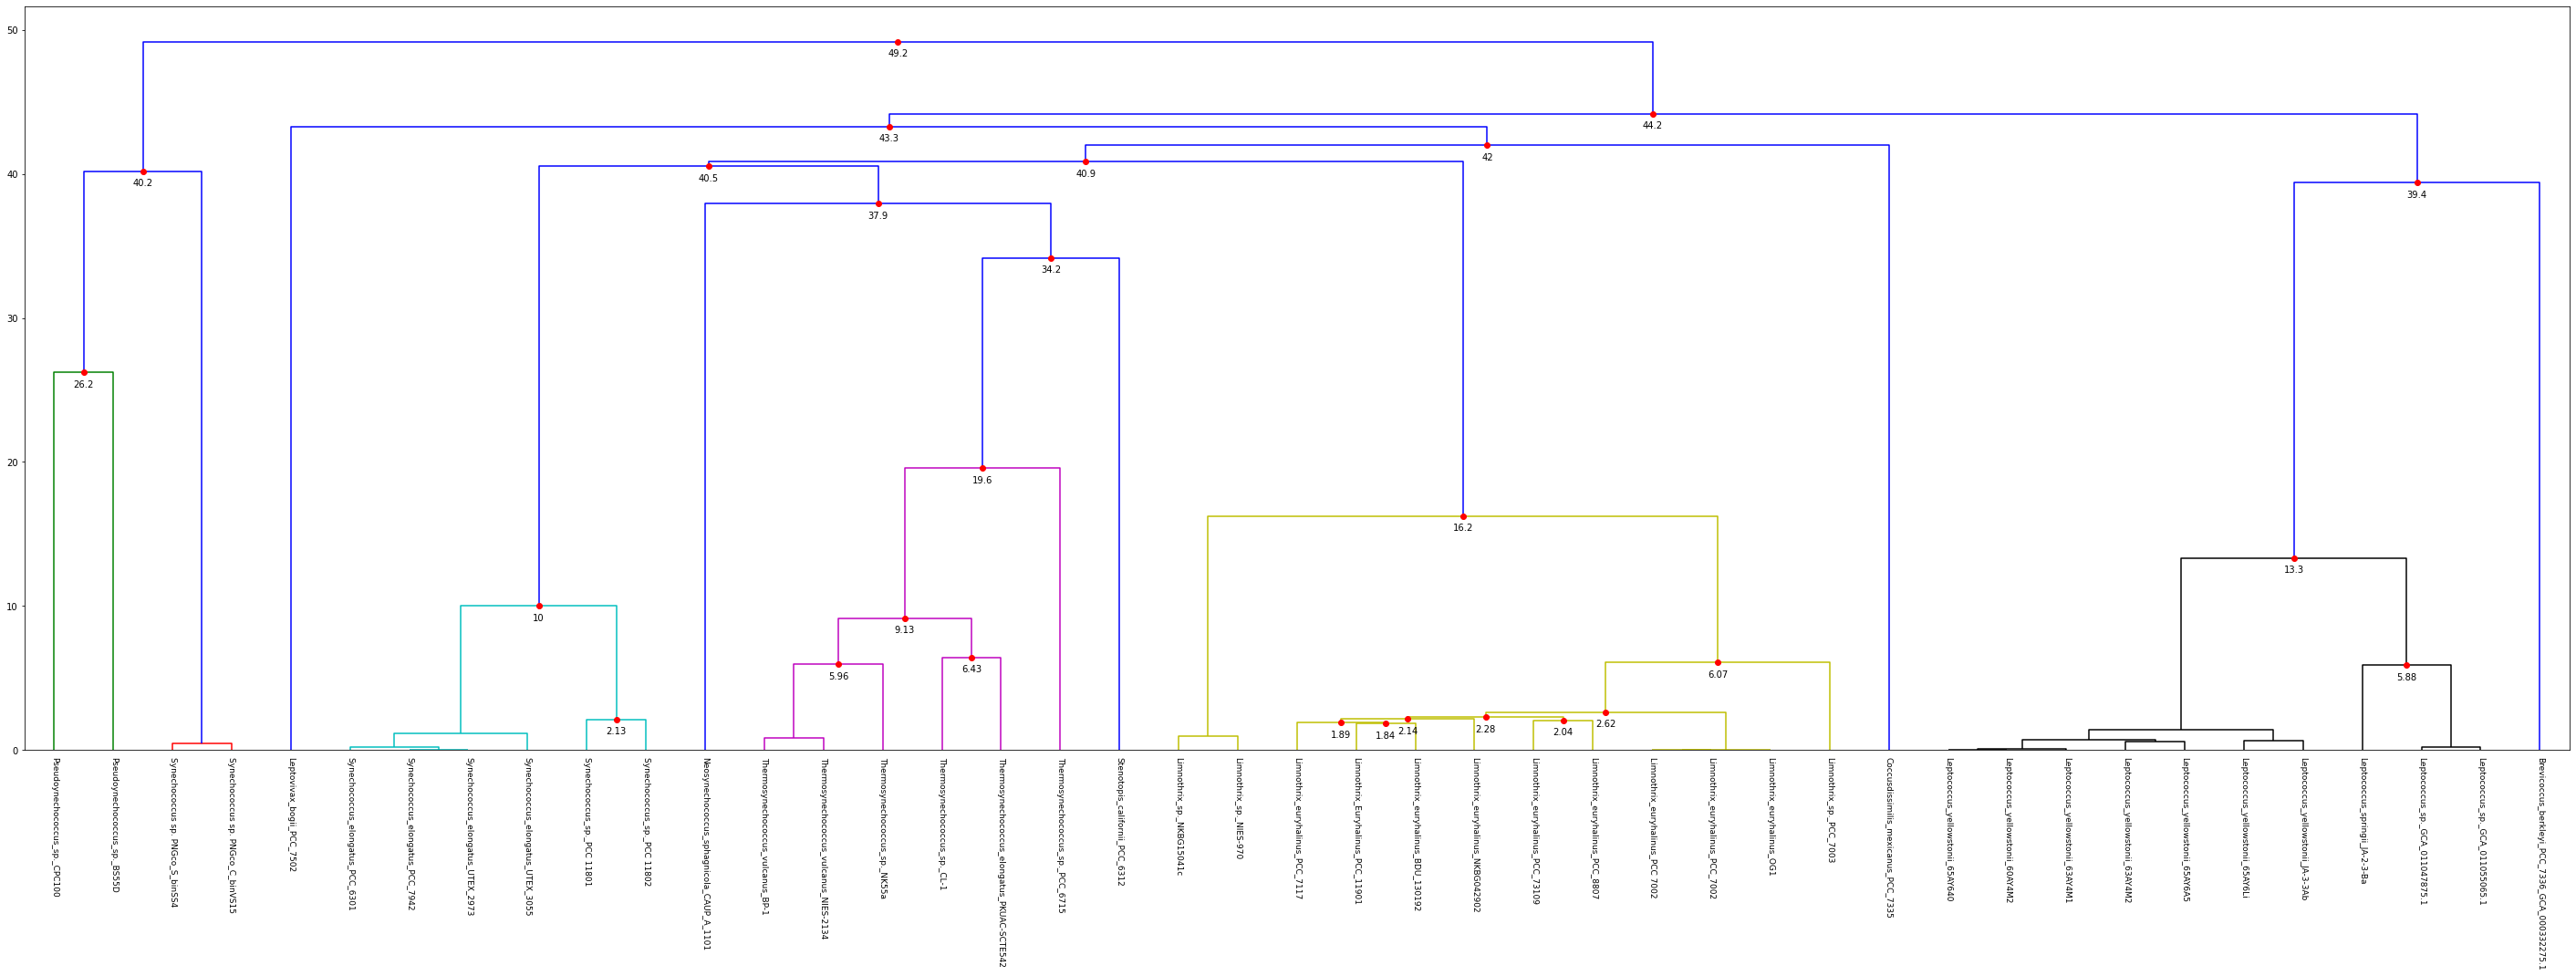

In [28]:
Z, columns = hclust("../data/comparem/output/aai/aai_summary.tsv", 
                    metadata=metadata[(metadata['is_synecho']) & (metadata['quality_filter']) & ~(metadata['label'].apply(lambda s: any([i in s for i in [
                        "Parasynechococcus", "Pseudosynechococcus", "Vulcanococcus", "Regnicoccus", "Lacustricoccus", "Inmanicoccus", "Synechospongium"]])))])
plot_hclust(Z, columns, figsize=(50,15), save="../data/plots/aai/aai_other_cyano.png")

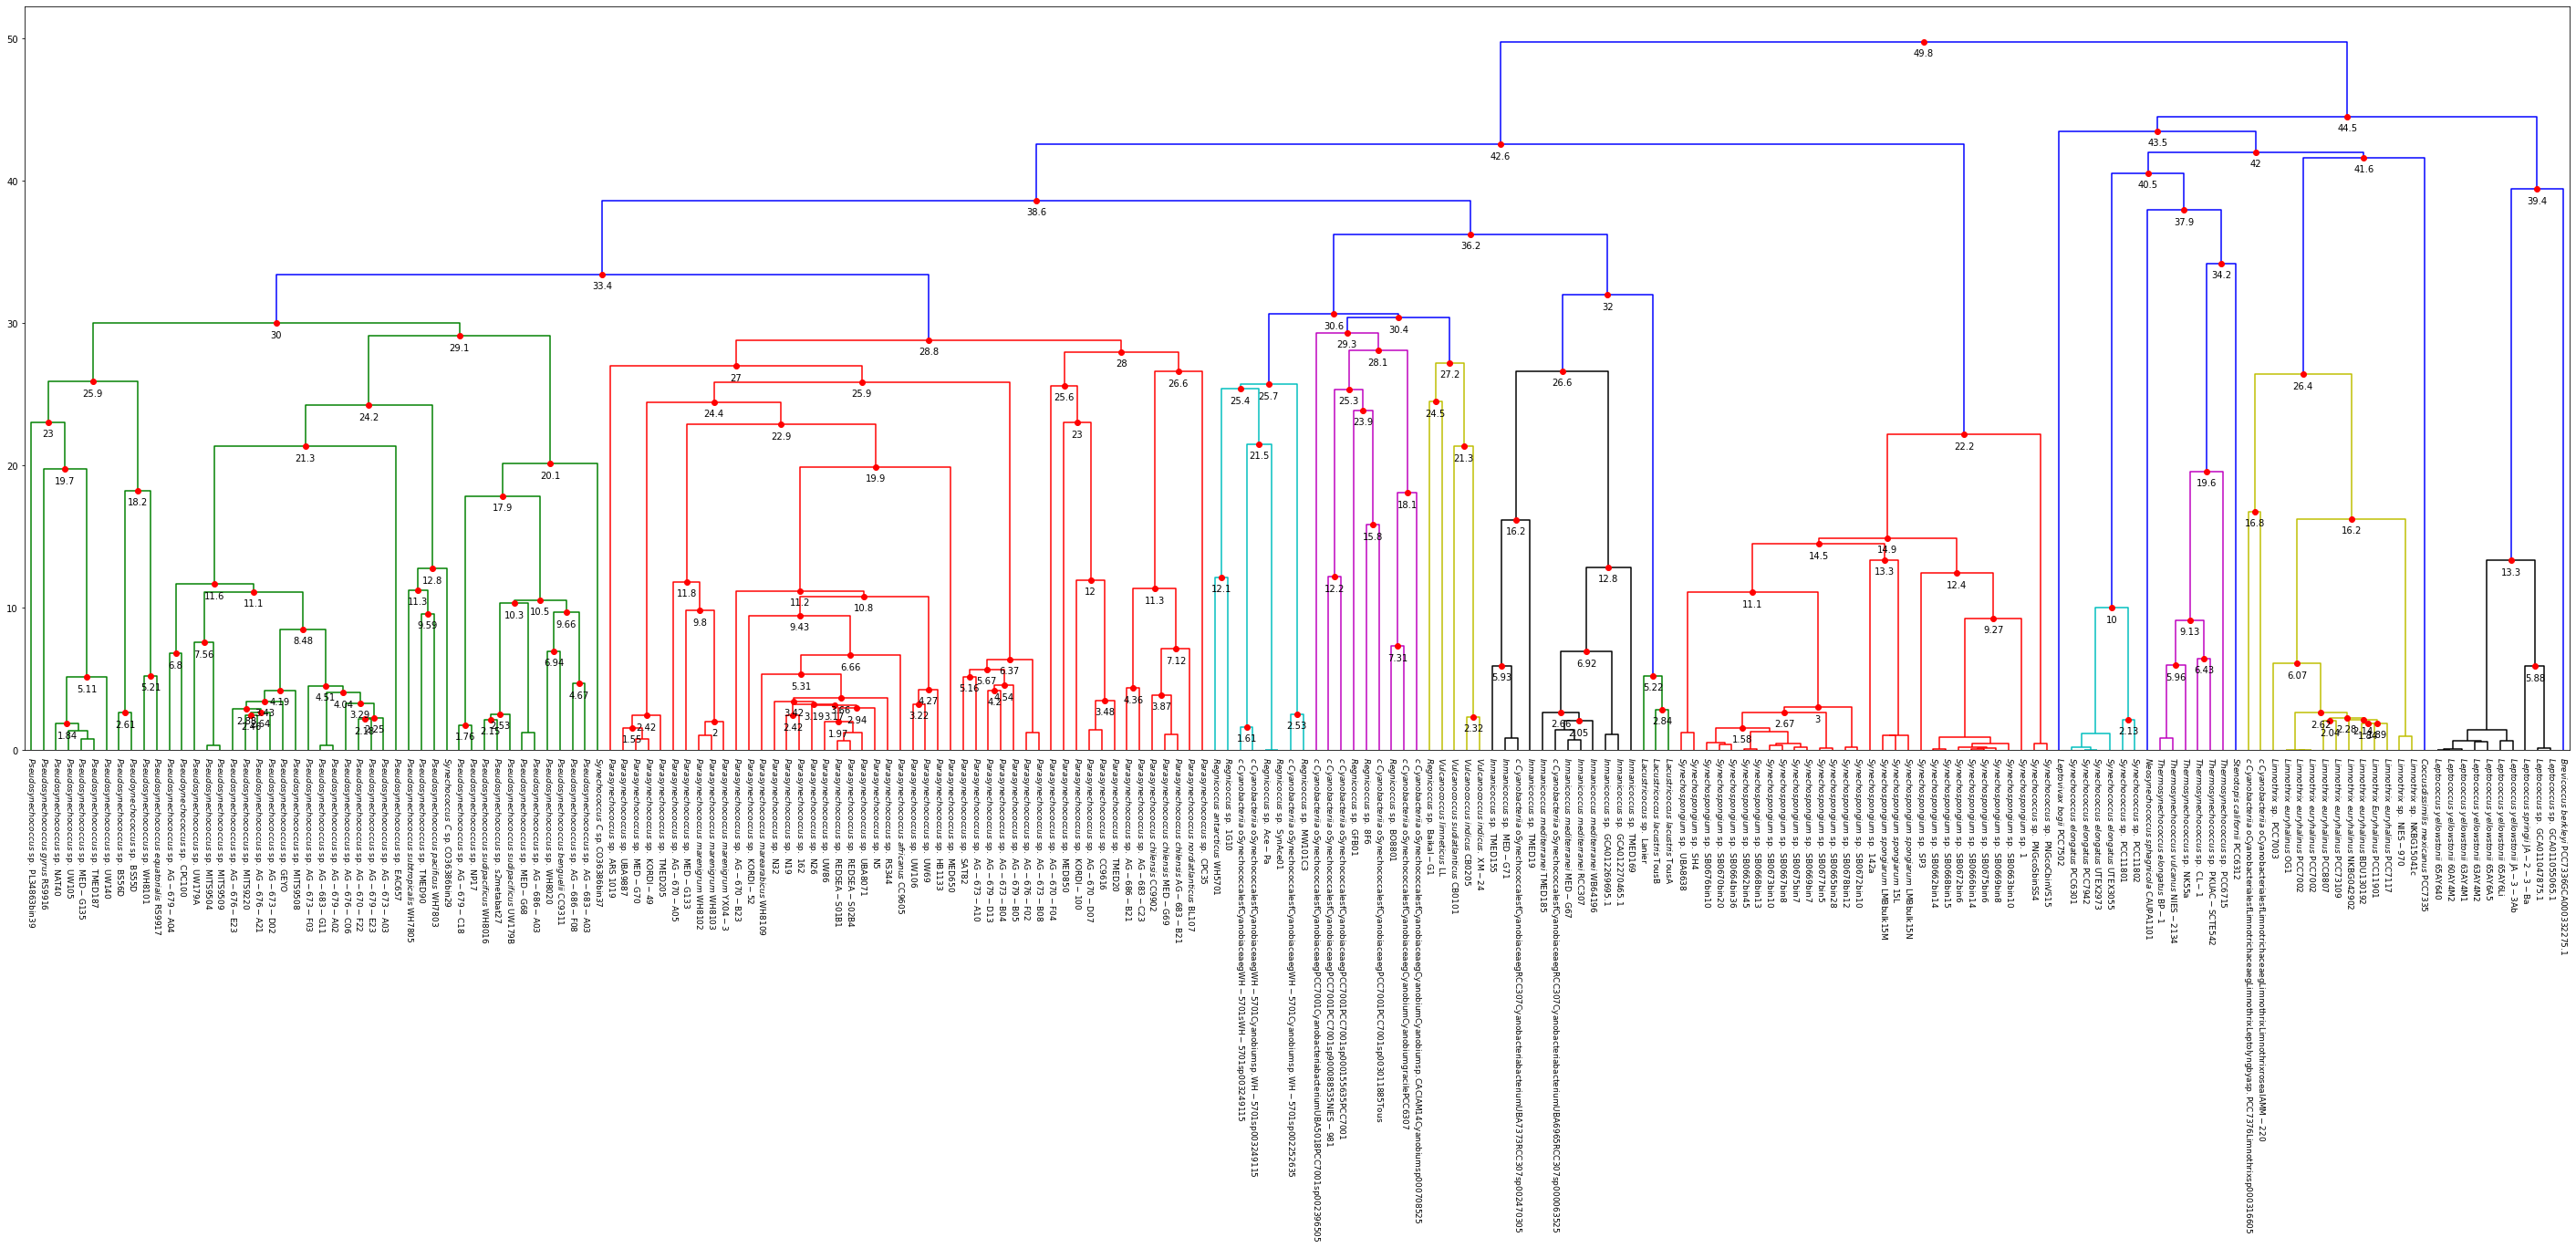

In [84]:
metadata = pd.read_csv("../data/metadata.csv")
metadata['no_genus'] = metadata.groupby('new_genus')[
    'new_genus'].transform('count').map(int, na_action="ignore")
metadata['label'] = metadata['label'].apply(lambda row: parse_label(row))
Z, columns = hclust("../data/comparem/output/aai/aai_summary.tsv", 
                    metadata=metadata[(metadata['is_synecho']) & (metadata['quality_filter']) & (metadata['no_genus'] > 0) | (metadata['label'].str.contains("Brevicoccus"))])
plot_hclust(Z, columns, figsize=(50,15), save="../data/plots/aai/synechos_filtered.png")